example executive summary [here](https://www.proposify.biz/blog/executive-summary)

# Executive Summary

- In Natural Language Processing, the target is for computers to correctly interpret natural language e.g. an provide meaningful interpretation. In the case of this project the power of machine learning to classify phrases and sentences will be examined.
- Objective is to :  

    1. Determine effectiveness of python models at NLP and classification of socially defined online communities  
    2. To decide if there may be a redundancy in having subreddits   


- Data is extracted from the website [Reddit.com](https://www.reddit.com). Collecting the titles from the subreddits as documents.
- Two vectorisers `CountVectorizer` and `TfidfVectorizer` are considered for the model to analyse.
- Machine Learning Classifiers (`Naive Bayes`, `Random Forest`, `Adaboost`, `VotingClassifier`, `SVM` and `Logistic Regression`) will be considered to determine if a doc belongs to either subreddit.
- Data will be split into ***train*** and **test** sample. Models are trained on the ***train*** sample and used to predict the ***test*** sample. The best model is determined by **accuracy** in predicting the ***test*** sample.


## Problem Statement

- The Goal of this project is to use python code classifiers to determine if a subreddit title belongs to "stocks" or "StockMarket"
- Find the best model given the following tools
    vectorisers: `CountVectorizer`, `TfidfVectorizer`  
    Estimators: `Naive Bayes`, `Random Forest`, `Adaboost`, `VotingClassifier`, `SVM`, `Logistic Regression`
    
## Assumptions
1. All information needed for classification resides in the title which is transformed to lower-cased words. 
2. Lemmatising and Stemming was another stepped that was avoided during this project due to the short-lived nature of the posts, this so most of the posts will be current, the presence of past tense may be useful in classifying types of posts on each side. 

_Fixed Variables_
-  vectorisers: stop_words = 'english'

In [2]:
import requests
import pandas as pd
import numpy as np
import time
np.random.seed(42)

# Import visualisations
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Import train test split
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

# Import CountVectorizer.
from sklearn.feature_extraction.text import CountVectorizer

#import confusion matrix fxn
from sklearn.metrics import confusion_matrix, plot_roc_curve, plot_confusion_matrix

# import models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

## 0. Extracting data from Subreddits
After comparing results of 500 and 8000 data points per subreddit revealed an improvement of about 5% in score leads to this project using ~1600 datapoints.

*runtime is long, skip to end of 1.1 to import dataset for faster results*

In [3]:
# create a function to take subreddit and desired size of corpus
def df_subreddit(subreddit, size):
    url = 'https://api.pushshift.io/reddit/search/submission'
    df = []
    params = {
            'size': 100,
            'subreddit': subreddit
        }
    data = requests.get(url,params).json()
    df.append(pd.DataFrame(data['data']))

    for i in range((size-1)//100):
        params['before'] = min(df[-1]['created_utc'])
        data = requests.get(url,params).json()
        df.append(pd.DataFrame(data['data']))
        
    df = pd.concat(df,ignore_index=True)
    
    return df

In [4]:
# collect multiple api pulls for "stocks" subreddit
start_time = time.time()

df_stocks = df_subreddit('stocks', 8000)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 121.515 seconds


In [5]:
# collect multiple api pulls for "StockMarket" subreddit
start_time = time.time()

df_stockm = df_subreddit('StockMarket', 8000)

elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 130.690 seconds


# 1. Create DataFrame

## 1.1 Engineer target feature to turn `source_feature` into a 1/0 column, where 1 indicates `stocks` subreddit.

- combine both subreddits
- instead of managing missing data we target the 'title'. also self text is limited due to the high number of [removed] phrases implying there may have been many moderator removed posts
- remove duplicates for only unique phrases

In [6]:
# create a combined df using UNIQUE title and if stocks = 1 StockMarket = 0
# ensure they are all unique values
d1 = {'title' : df_stocks['title'].unique(), 'stocks' : 1}
d2 = {'title' : df_stockm['title'].unique(), 'stocks' : 0}

df = pd.concat([pd.DataFrame(data=d1),pd.DataFrame(data=d2)],ignore_index=True)

In [7]:
print('Proportion of each class is printed below to ensure there is even data distribution')
print(df['stocks'].value_counts(normalize=True))

Proportion of each class is printed below to ensure there is even data distribution
1    0.501872
0    0.498128
Name: stocks, dtype: float64


In [8]:
# create csv for future use
df.to_csv('data.csv',index=False)

In [9]:
df = pd.read_csv('data.csv')

## 1.2 EDA

### 1.2.1 Word Cloud

The words in both are quite similar so it is suspected that how the words may be strung or specific trigger words can identify differing subreddits

In [10]:
corpus_stocks = df.loc[df['stocks']==1]['title']
corpus_stockm = df.loc[df['stocks']==0]['title']

In [11]:
sample = corpus_stocks.sample(3).values
print(sample)
len(sample[0])

['What will happen to CTRM?'
 'Here is a Market Recap for today Thursday, August 26, 2021'
 'FB down by 4%']


25

In [12]:
sample = corpus_stockm.sample(3).values
print(sample)
len(sample[0])

['Rh traders' 'Nintendo Stock $NTDOY a Good Long-Term Compounder'
 'What if I do a wash sale and hold for 1 year+']


10

`stocks` subreddit has more questions being asked by users while `StockMarket` subreddit provides more passive advice

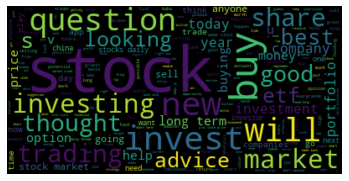

In [13]:
# Generate wordcloud for stocks subreddit
text = ' '.join(corpus_stocks.tolist()).lower()
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

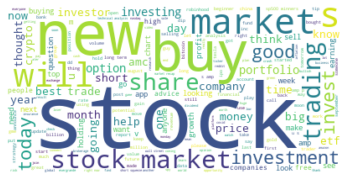

In [14]:
# Generate wordcloud for StockMarket subreddit
text = ' '.join(corpus_stockm.tolist()).lower()
wordcloud = WordCloud(background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

The word cloud shows how similar the words are used in both subreddit title posts.

### 1.2.2 Word Frequency (TOP 20 WORDS)

(refer to section [3.1](#3.1-Word-Frequency-(TOP-20-WORDS)))
There is very little difference in the top words, it is likely the model will have to determine the target classifications by considering the smaller frequency words

## 2. Split data into `X` and `y`

In [15]:
len(df)

15223

In [16]:
X = df[['title']]
y = df['stocks']

## 3. Split data and Tokenisation

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify=y)

In [18]:
# Turn our text into features
# Instantiate our CountVectorizer.
cvec = CountVectorizer(max_features = 500, stop_words = 'english')

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(),
                          columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['title']).todense(),
                         columns = cvec.get_feature_names())

### 3.1 Word Frequency (TOP 20 WORDS)

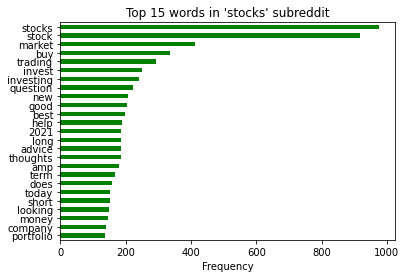

In [19]:
stocks_top_words = pd.DataFrame(cvec.fit_transform(corpus_stocks).todense(),
                          columns = cvec.get_feature_names())

fig, ax = plt.subplots()
stocks_top_words.sum().sort_values().tail(25).plot.barh(ax=ax, color='green')
ax.set_title("Top 15 words in 'stocks' subreddit")
plt.xlabel('Frequency', fontsize=10)
plt.show();

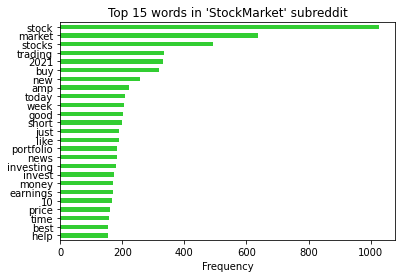

In [20]:
stockm_top_words = pd.DataFrame(cvec.fit_transform(corpus_stockm).todense(),
                          columns = cvec.get_feature_names())

fig, ax = plt.subplots()
stockm_top_words.sum().sort_values().tail(25).plot.barh(ax=ax, color='limegreen')
ax.set_title("Top 15 words in 'StockMarket' subreddit")
plt.xlabel('Frequency', fontsize=10)
plt.show();

### 3.2 Differences in the subreddits

To differentiate the subreddits, the use of different words is necessary to determine for classifying the post titles. Taking the mean of word frequences, the difference in the averages for each word can indicate if there is a quantifiable difference in the use of certain words

In [21]:
difference = (stocks_top_words.mean()-stockm_top_words.mean())
len(difference[difference.isnull()].index.tolist())

278

There are 270 words that are either only in `stocks` or `StockMarket`

In [22]:
difference.tail()

year      -0.004058
years      0.001763
yield           NaN
young           NaN
youtube         NaN
dtype: float64

In [23]:
print('Is the word "wrong" in StockMarket? ',('wrong' in stockm_top_words.columns))
print('Is the word "wrong" in stocks? ',('wrong' in stocks_top_words.columns))

Is the word "wrong" in StockMarket?  True
Is the word "wrong" in stocks?  False


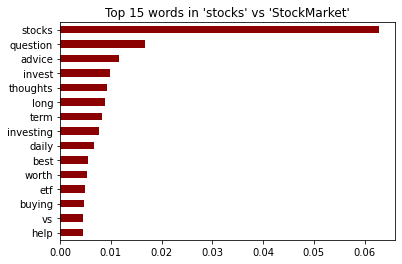

In [24]:
fig, ax = plt.subplots()
difference = (stocks_top_words.mean()-stockm_top_words.mean()).dropna().sort_values()

difference.tail(15).plot.barh(ax=ax, color='darkred')
ax.set_title("Top 15 words in 'stocks' vs 'StockMarket'");

On average words like 'stocks', 'question', 'advice' occurs occur more frequently in 'StockMarket' than 'stocks'

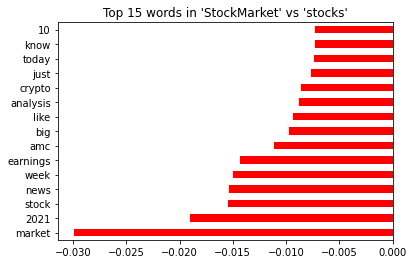

In [25]:
fig, ax = plt.subplots()
difference = (stocks_top_words.mean()-stockm_top_words.mean()).dropna().sort_values()

difference.head(15).plot.barh(ax=ax, color='red')
ax.set_title("Top 15 words in 'StockMarket' vs 'stocks'");

On average words like 'market', '2021', 'news' occurs occur more frequently in 'stocks' than 'StockMarket'.

There is reason to believe that even though there is a high number of similar words used. There are some words that may be used in combination to differentiate a post to `stocks` or `StockMarket` subreddit.

As seen above, the difference in the average frequency is very small. But there may be a linear combination or parametric relationship so that Random Forest or Logistic Regression can use to predict a post titles' classification.

## 4. Fit models

*run time of model training is long, skip to 5.1 for model comparisons and best model training for faster review. )*

Before the models are plot a baseline of 50% accuracy is used. Because if we assume that a title can be tagged as 'stocks' will have accuracy of 50% on any train or test dataset

In [26]:
print(f'Baseline test score: {y_train.mean():.2f}')

Baseline test score: 0.50


In [27]:
# results dataframe is used to collect results from experiments run 
results = pd.DataFrame(columns=['model','parameters','train','test'])

#### 4.1 Fit a Random Forest model!

Random Forest is chosen over Extra Trees based on an single run with train data sets and assumed that Random Forest is superior at predicting this dataset over Extra Trees model.(see `code3.ipynb`, Section 4.2)

GridSearchCV performed with the following parameters:  
- 'n_estimators': [100, 200],  
- 'max_depth': [1, 5]
        
1. Short tree depth is used to reduce over fitting. (see `code3.ipynb`, Section 4.2 for overfitted models)
2. Higher n_estimators are used but less than 300 because of long compute times
  
best parameters were {'max_depth': 3, 'n_estimators': 200}

In [28]:
"""rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [1, 3]
}

gs = GridSearchCV(rf, param_grid=rf_params, cv=5)
gs.fit(X_train_cvec, y_train)
print(gs.best_score_)
gs.best_params_

print(gs.score(X_train_cvec, y_train))
print(gs.score(X_test_cvec, y_test))"""

rf = RandomForestClassifier(max_depth= 3, n_estimators= 200, random_state=42)
rf.fit(X_train_cvec, y_train)

#record the scores
train_score = rf.score(X_train_cvec, y_train)
test_score = rf.score(X_test_cvec, y_test)

In [29]:
new_model = pd.DataFrame([['RF',rf.get_params(deep=False),train_score,test_score]]
                         ,columns=results.columns.tolist())
results = results.append(new_model)

#### 4.2 Fit a Ada boost model!

In [30]:
"""ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
ada_params = {
    'n_estimators': [100,200],
    'base_estimator__max_depth': [1,2],
    'learning_rate': [.9, 1.]
}
gs = GridSearchCV(ada, param_grid=ada_params, cv=3)
gs.fit(X_train_cvec, y_train)"""

ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                         learning_rate=0.9,n_estimators=200, random_state=42)
ada.fit(X_train_cvec, y_train)

#record the scores
train_score = ada.score(X_train_cvec, y_train)
test_score = ada.score(X_test_cvec, y_test)

In [31]:
new_model = pd.DataFrame([['AdaBoost',ada.get_params(deep=False),train_score,test_score]]
                         ,columns=results.columns.tolist())
results = results.append(new_model)

In [32]:
# Saving the results of Random Forest and AdaBoost to .csv
results['vectorizer'] = 'CountVectorizer'
results.to_csv('../results/code1_results.csv')

## 5.1 Collect all results

Experiments are also run for varying models, vectorisers and ngrams. More details will be provided in Appendix A below. The results are collected below

In [33]:
# collecting results from .csv files
overall_results = []

for report_no in [1,3,4,5]:
    overall_results.append(pd.read_csv(f'../results/code{report_no}_results.csv'))
    
    final_results = pd.concat(overall_results,ignore_index=True).drop(columns='Unnamed: 0').sort_values(by='test',ascending=False)
    
# compute the % delta of test to train
final_results['delta'] = (final_results.test-final_results.train)/final_results.train*100

In [34]:
print(f'Total models run: {len(final_results)}')
print(f'Best model is chosen based on lowest train-test delta%\n\
estimator: {final_results.loc[final_results.delta.idxmax()].model}\n\
test accuracy: {final_results.loc[final_results.delta.idxmax()].test:.3f}\n'
        f'train accuracy: {final_results.loc[final_results.delta.idxmax()].train:.3f}\n'
        f'delta: {final_results.delta.max():.1f}%')

Total models run: 26
Best model is chosen based on lowest train-test delta%
estimator: RF
test accuracy: 0.582
train accuracy: 0.597
delta: -2.5%


## 5.2 Best ngram

In [35]:
import re

In [36]:
x=[]
y=[]
for para, test in zip(final_results['parameters'],final_results['test']):
    if bool(re.findall('\(\d, \d\)',str(para))):
        x.append(re.findall('\(\d, \d\)',para)[0])
        y.append(test)

        
ngram_scores = pd.DataFrame(data={'ngram':x,'accuracy':y}).sort_values(by='ngram')

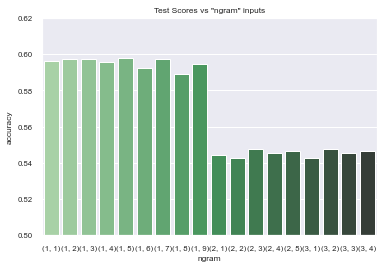

In [37]:
sns.set_theme(style="whitegrid")
sns.set(font_scale = .7)
plt.ylim(.5,.62)

sns.barplot(x=ngram_scores.ngram,y=ngram_scores.accuracy,palette=sns.color_palette("Greens_d", len(y))).set(title='Test Scores vs "ngram" inputs');

ngram = (1,5), is chosen as the best hyperparameter because it has the highest test score. (see `code4.ipynb`)

## 5.3 Best Tokenizer/Vectorizer

In [38]:
# Instantiate our CountVectorizer.
cvec = CountVectorizer(stop_words = 'english',ngram_range=(1,5),max_features=3000)
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(),
                          columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['title']).todense(),
                         columns = cvec.get_feature_names())

In [39]:
X_train_cvec.filter(regex='\s').sum().sort_values().tail(20)

investments sp500      33
daily market           35
make money             36
need advice            36
stock price            38
meme stocks            42
short term             44
market crash           45
need help              45
technical analysis     47
wall street            50
amp 500                52
market recap today     59
recap today            59
stocks daily           63
sp500 winners          63
short squeeze          65
market recap           66
long term             138
stock market          253
dtype: int64

In [40]:
len([x for x in X_train_cvec.columns if len(x.split())>2])

204

Based on test scores the best vectoriser is CountVectoriser (see `code3.ipynb`)

Delimiting the # of `max_features` improved the performeance of LogReg, while it was 500 for previous models we use 3000 because an unlimited `max_features` will create more features than available data. (see `code5.ipynb`)

## 5.4 Best Estimator  
the best model is as follows:  
- model                                                        RandomForestClassifier
- parameters   (max_depth=3, n_estimators=200)
- train                                                  0.61	
- train  0.59
- vectorizer                                      CountVectorizer
    

In [41]:
# simplify the model names for easy reference when plotting
def rename_models(m):
    if 'VotingClassifier(' in m:
        return 'Vote'
    elif 'AdaBoostClassifier(' in m:
        return 'AdaBoost'
    elif 'nb' in m:
        return 'NB'
    elif 'DecisionTreeClassifier(' in m:
        return 'DT'
    elif 'RandomForestClassifier(' in m:
        return 'RF'
    elif 'lr' in m:
        return 'LogReg'
    elif 'svm' in m:
        return 'SVM'
    else:
        return m
    

final_results['estimator'] = final_results.model.apply(lambda x :rename_models(x))

In [42]:
# pick the models with the lowest delta i.e. least overfit

res = []

for m in final_results['estimator'].unique():
    temp = final_results[final_results['estimator']==m]
    res.append(temp[temp['delta']==temp['delta'].max()])
    
final_results = pd.concat(res,ignore_index=True)

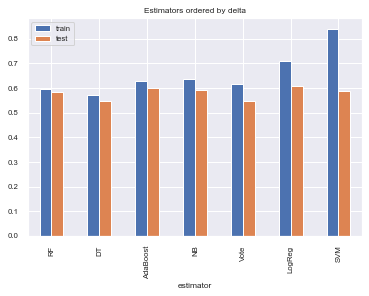

In [43]:
# plotting the best test scores for each estimator
# order the models with lowest delta first

models = pd.DataFrame(final_results.groupby('estimator').max().sort_values(by='delta',ascending=False))
models[['train','test']].plot(kind='bar')
plt.title('Estimators ordered by delta');

In [44]:
models

,model,parameters,train,test,vectorizer,delta
estimator,,,,,,
RF,RF,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.597004,0.581976,CountVectorizer,-2.517341
DT,DecisionTreeClassifier(),"{'max_depth': 5, 'n_estimators': 200, 'n_gram'...",0.570547,0.547713,TfidfVectorizer,-4.002092
AdaBoost,AdaBoost,"{'algorithm': 'SAMME.R', 'base_estimator': Dec...",0.627223,0.601944,CountVectorizer,-4.030191
NB,nb,NaN,0.637173,0.590801,TfidfVectorizer,-7.277754
Vote,"VotingClassifier(estimators=[('tree',\n ...","{'ada__n_estimators': 50, 'tree__max_depth': 1...",0.617873,0.549035,TfidfVectorizer,-11.141037
LogReg,lr,"{'Cs': 10, 'class_weight': None, 'cv': 5, 'dua...",0.710144,0.609305,CountVectorizer,-14.199784
SVM,svm,"{'memory': None, 'steps': [('standardscaler', ...",0.840134,0.586307,CountVectorizer,-30.212657


Although LogReg shows to be the best test model, it is not fairly compared because the model used in the above graph is the only one with unlimited features in the CountVectoriser(). On the other hand other estimators like RF and VotingClassifier(Vote) use GridSearchCV and providing such simulations with an expanded feature set will be computationally exhausting.

However there may not be sufficient information in the post title to explain the classification

Random Forest with following advantages:
1. Has presently the best delta of train-test score
2. there is feature importance
3. not overfitt (<3% difference)

Disadvantages:
1. May not be able to express non-linear relationships in the features (however they may be addressed by the method of tokenisation)
2. Model is still overfit and may require further pruning.

In [45]:
# the best model
models.loc['RF']

model                                                        RF
parameters    {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...
train                                                  0.597004
test                                                   0.581976
vectorizer                                      CountVectorizer
delta                                                 -2.517341
Name: RF, dtype: object

## 5.5 Combine Best Tokenizer/Vectorizer, ngram and Estimator

### 5.5.1 CountVectorizer and Random Forest
Tokenizer/Vecotrizer: CountVectorizer(stop_words = 'english',ngram_range=(1,5),max_features=3000)  
Estimator: RandomForestClassifier(max_depth=3, n_estimators=200)

In [46]:
# retokenize
cvec = CountVectorizer(max_features = 3000, stop_words = 'english')

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['title']).todense(),
                          columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['title']).todense(),
                         columns = cvec.get_feature_names())



In [47]:
rf1 = RandomForestClassifier(random_state=42,max_depth=3, n_estimators=200)
rf1.fit(X_train_cvec, y_train)

RandomForestClassifier(max_depth=3, n_estimators=200, random_state=42)

In [48]:
from joblib import dump, load

In [49]:
# save best model
dump(rf1, 'best_model.joblib')

['best_model.joblib']

In [50]:
# load
rf2 = load('best_model.joblib')

In [51]:
train_score = rf1.score(X_train_cvec, y_train)
test_score = rf1.score(X_test_cvec, y_test)

In [52]:
train_score,test_score 

(0.6096172374529211, 0.594587493431424)

In [53]:
f'{(train_score-test_score)/train_score*100:.1f}% difference in train-test score'

'2.5% difference in train-test score'

### 5.5.2 Scoring the best model

In [54]:
predictions = rf2.predict(X_test_cvec)
print(confusion_matrix(y_test, predictions).T)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print("True Negatives:\t%s" % tn)
print("False Positives:\t%s" % fp)
print("False Negatives:\t%s" % fn)
print("True Positives:\t%s" % tp)

[[ 572  219]
 [1324 1691]]
True Negatives:	572
False Positives:	1324
False Negatives:	219
True Positives:	1691


In [55]:
print(f'Accuracy\t{(tp+tn)/(tp+tn+fp+fn)*100:.1f}')
print(f'Sensitivity\t{tp/(tp+fn)*100:.1f}')
print(f'Specificity\t{tn/(tn+fp)*100:.1f}')

Accuracy	59.5
Sensitivity	88.5
Specificity	30.2


<Figure size 2160x1440 with 0 Axes>

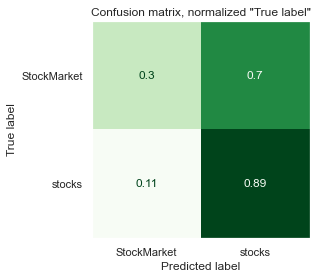

In [68]:
plt.figure(figsize=(30, 20))
           
plot_confusion_matrix(rf2, X_test_cvec, y_test, cmap='Greens', colorbar=False, normalize='true',
                      display_labels=['StockMarket', 'stocks'])
plt.grid(False)
plt.title('Confusion matrix, normalized "True label"' );

# 6. Visualisations

## 6.0 Subreddit
choice of subreddit matters, as seen here even though `stocks-Stockmarket` is used in final analysis. A categorical dissimmilar topic like `Paleontology` is a lot easier for a model to differentiate. (see `code2.ipynb`)

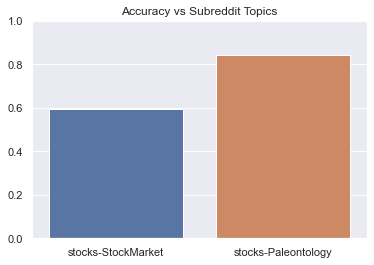

In [69]:
# plot the performance of each test vs others
y = [0.594237,0.843284]
x = ['stocks-StockMarket','stocks-Paleontology']

sns.set_theme(style="whitegrid")
sns.set(font_scale = 1)
plt.ylim(0,1)

sns.barplot(x=x,y=y).set(title='Accuracy vs Subreddit Topics');

## 6.1 Best Model - Visualisations (Random Forest)

### 6.1.1 Best Model - AUC

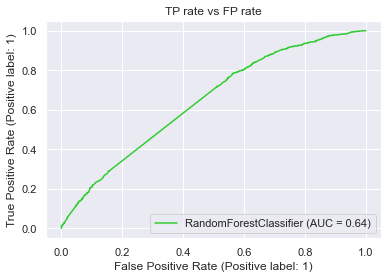

In [70]:
rf_roc = plot_roc_curve(rf2, X_test_cvec, y_test,color='limegreen')
plt.title('TP rate vs FP rate');

### 6.1.2 Random Forest

In [71]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [72]:
# use the best RF model to find some important words or phrases
models.loc['RF']

model                                                        RF
parameters    {'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...
train                                                  0.597004
test                                                   0.581976
vectorizer                                      CountVectorizer
delta                                                 -2.517341
Name: RF, dtype: object

In [73]:
forest_importances = pd.Series(rf2.feature_importances_, index=X_train_cvec.columns)
forest_import_20_top = forest_importances.sort_values(key=lambda x: abs(x)).tail(20)
forest_import_20_bot = forest_importances.sort_values().head(20)

### 6.1.3 Random Forest Most Important Words

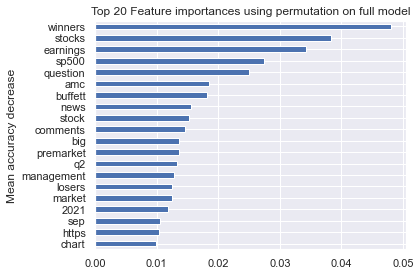

In [74]:
fig, ax = plt.subplots()
forest_import_20_top.plot.barh(ax=ax)
ax.set_title("Top 20 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### 6.1.4 Random Forest Least Important Words

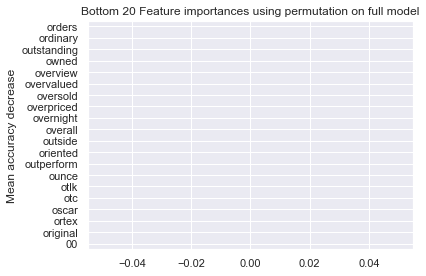

In [75]:
fig, ax = plt.subplots()
forest_import_20_bot.plot.barh(ax=ax)
ax.set_title("Bottom 20 Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

### 6.2.3 DECISION TREE, TREE VIZ

In [76]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

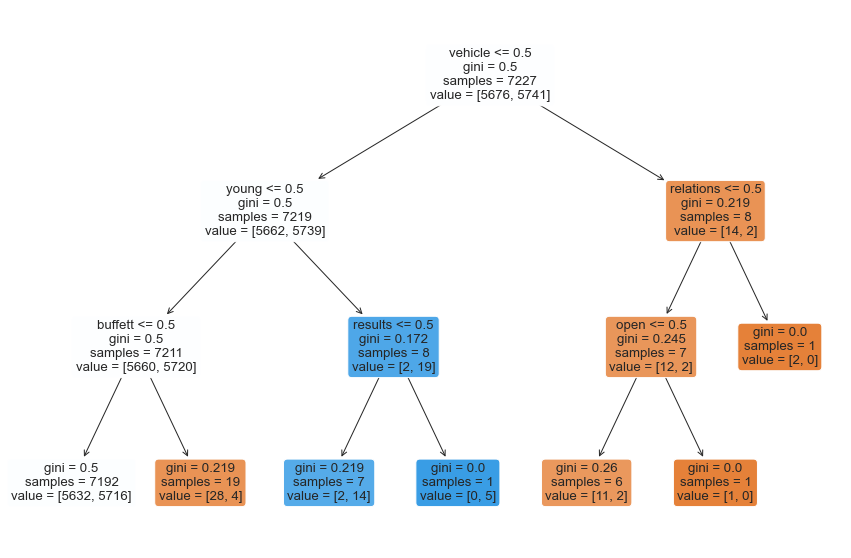

In [77]:
fig = plt.figure(figsize=(15, 10))
plot_tree(rf2.estimators_[5], 
          feature_names=X_train_cvec.columns,
          filled=True, impurity=True, 
          rounded=True);

# Conclusions 

The model with based on trials of: 

- Tokenizer/Vecotrizer: `CountVectorizer`, `TfidfVectorizer`  
- Estimators: `Naive Bayes`, `Random Forest`, `Adaboost`, `VotingClassifier`, `SVM`, `Logistic Regression`

After trialling some range of datapoints, ngram, estimators, number of features, the model with the best performance is: 
- CountVectorizer(stop_words = 'english',ngram_range=(1,5),max_features=3000)  
- Estimator: RandomForestClassifier(random_state=42, max_depth=3, n_estimators=200,n_jobs=-1)

**Baseline accuracy is 0.5 and best model test score is 0.61 with 20% improvement.**

Objectives:
    1. Determine effectiveness of python models at NLP and classification of socially defined online communities  
    2. To decide if there may be a redundancy in having subreddits

**There is significant score improvement to the baseline of the model therefore the model can be useful to distinguish a subreddit however the error rate is still 39%. There appears to be a high amount of overlap in the topics and so the models find it hard to distinguish. However the content in the title may not be sufficient to prove that the groups are distinct. Other aspects such as media and length of selftext should be relevant but were not available due to the API restrictions.**

# Recommendations
1. EDA and project scores allude that high `max_feature` contributing to favourable scores because of the inclusion of more rare words (where `stocks` and `StockMarket` share many similar words).  Towards the end of the project, the `max_feature` hyperparameter appears to be very significant because as it was unlimited during the initial Logistic Regression fit there was an improvement in scores. However this lead to overfitting and the current model is still overfit. Including more information like self text or reading the images will help to provide more data to interpret the post.

2. Although Stemming and Lemmatising was avoided for this analysis. It may be helpful to the model to allow for a more generalised regression. Also be able to consolidate words and reduce the need for so many features.

3. Further work can be done to compare the model Accuracy, Sensitivity and Specificity against human classifications in a blind test. Trails can be performed with the model and human trained or read the same number of articles and compare the scores. Additionally the current best model trained against a large sample can be used to see how the former scores differ.


---

# Appendix A

## 4.x Tokenizer/Vectorizer and Hyperparameter trails

While starting with `code1` already included `GridSearch` of some models there are other models and hyperparamters are tested. `code1`,`code2`,`code3`,`code4`,`code5` iterations are based on token/vectorizer and hyperparamtetes are trailed. While you can review them in the folder all of their results will be reviewed in this notebook `code1`.

##### [code1.ipynb](code1.ipynb)
Finding testing 4 models. Tokenized and vectorized with with CountVectorizer  
- Tokenizer  
    CountVectorizer
- Model  
    4.1 Random Forest (GridSearch)  
    4.2 Adaboost(Decision Tree)  
    
*Random Forest (RF) has the best score and the lowest difference in train and test score * 

#### [code2.ipynb](code2.ipynb)
Comparing results if `StockMarket` subreddit is swapped for `Paleontology`  
(both using CountVectorizer)

- Tokenizer  
    CountVectorizer
- Model  
    4.1 Naive Bayes   
    4.2 Random Forest (GridSearch)  
    4.3 Voting Classifier (RandomForest, AdaBoost(Decision Tree))
    
Taking Random Forest model comparing:
- `stocks`, `StockMarket` test score is 0.594
- `stocks`, `Paleontology` test score is 0.870  

Taking Voting Classifier model comparing:
- `stocks`, `StockMarket` test score is 0.594
- `stocks`, `Paleontology` test score is 0.870  


*The types of subreddits chosen will affect the accuracy of the classifier*

#### [code3.ipynb](code3.ipynb)
Trialed TF-IDF over CountVectorizer.  
- Tokenizer  
    TfidfVectorizer
- Model  
    4.1 Naive Bayes   
    4.2 Random Forest (GridSearch)  
    4.3 Adaboost(Decision Tree)  
    4.4 Voting Classifier (RandomForest, AdaBoost(Decision Tree))
    
*Best model found to be RF. Negligible change and slight decrease in test score.*

#### [code4.ipynb](code4.ipynb)

Trialed various n-grams with RF.  
Created an iterator for ngram  
    - (1, x), where x is 1 to 9  
    - (2, x), where x is 2 to 6  
    - (3, x), where x is 3 to 6   
Collate results

- Tokenizer  
    TfidfVectorizer
- Model  
    4.1 Random Forest (max_depth=20, n_estimators=100) 
    
*ngram (1,5) appears to be the best. increasing max ngram past does improve however this may be due to collinearity
increasing min ngram does not show to improve the performance*
    
#### [code5.ipynb](code5.ipynb)
Expanded code1 trials with two more models. Tokenized and vectorized with CountVectorizer
- Tokenizer  
    CountVectorizer (unlimited tokens ~2200 << # of rows ~1600)
- Model  
    4.1 Support Vector Machines    
    4.2 Logistic Regression 
    
LogReg is an effective model
    
*Random forest is chosen as the best model*